SentencePiece(unigram)

In [138]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
3.4.3
0.5.2


In [139]:
!pwd

/aiffel/aiffel/text_preprocess


In [140]:
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/aiffel/aiffel/text_preprocess': ['[Going Deeper(NLP)_RS4_1]. 텍스트 데이터 다루기.ipynb', '[Going Deeper(NLP)_RS4] 3. 멋진 단어사전 만들기 [프로젝트].ipynb', 'korean_spm.vocab', 'ratings.txt', 'ratings_test.txt.temp', 'ratings_train.txt', 'ratings_test.txt', 'korean_spm.model', '.ipynb_checkpoints']


In [141]:
f = open("/aiffel/aiffel/text_preprocess/ratings_train.txt")

In [142]:
train_data = pd.read_table(f)

In [143]:
x = open("/aiffel/aiffel/text_preprocess/ratings_test.txt")

In [144]:
test_data = pd.read_table(x)

In [145]:
all_data = pd.concat([train_data, test_data], ignore_index=True, axis=0)

# 결측치 제거
all_data.dropna(axis=0, inplace=True)

# 중복치 제거
all_data.drop_duplicates('document', keep='first')

# all_data의 document 컬럼을 sentence에 할당
sentence = all_data['document']

sentence

0                                       아 더빙.. 진짜 짜증나네요 목소리
1                         흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                             교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
199995            오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함
199996         의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO
199997                   그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다
199998       절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네
199999                                           마무리는 또 왜이래
Name: document, Length: 199992, dtype: object

Min length :  1
Max length :  146
Average length :  35


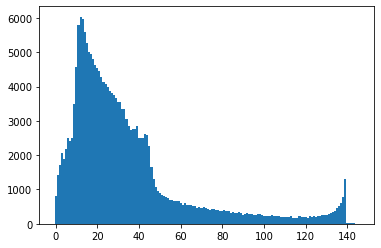

In [146]:
import matplotlib.pyplot as plt     # 시각화 라이브러리 matplotlib 모듈 실행

min_len = 999  # 최소길이
max_len = 0    # 최대길이
sum_len = 0    # 모든 문장의 길이를 더해서 총합 

for s in sentence:     
  if len(s) < min_len :
    min_len = len(s)
  if len(s) > max_len :
    max_len = len(s)
  sum_len += len(s)
# 각 문장의 최소길이, 최대길이, 평균길이를 출력
# 평균길이는 총 길이를 문장의 수로 나눈 값

print('Min length : ', min_len)
print('Max length : ', max_len)
print('Average length : ', sum_len // len(sentence))

sen_length_cnt = [0] * max_len
for sen in sentence:
  sen_length_cnt[len(sen)-1] += 1
# 문장 길이별 빈도수를 저장할 리스트 초기화
# 각 문장의 최대 길이만큼 리스트의 길이 설정
# for문에서는 각 문장의 길이 인덱스로 하여 'sen_length_cnt'의 해당 인덱스 값 1 증가
# 'sen_length_cnt' 리스트는 각 문장 길이별 빈도수 저장


plt.bar(range(max_len), sen_length_cnt, width=1.0)
plt.show()

In [147]:
# 주어진 문장 'Sentence'와 그에 해당하는 라벨'target'의 배열에서 문장의 길이가
# 특정범위 (최소문장'min_len'과 최대 문장'max_len'사이)에 들어가는 문장과 
# 그에 해당하는 라벨만 선택하여 새로운 리스트('filtered_sen',''filtered_target)에 추가

max_len = 200         # 최대문장길이 
min_len = 30          # 최소문장길이 

filtered_sen = []
filtered_target = []
# 길이 조건에 만족하는 문장과 그에 해당하는 라벨을 저장하는 빈 리스트 생성 


target = np.array(all_data['label'])
# 'all_data['label']에서 라벨 데이터를 가져와 numpy 배열로 변환

for s, t in zip(sentence, target):
  if (len(str(s)) < max_len) and (len(str(s)) >= min_len) :
    filtered_sen.append(s)
    filtered_target.append(t)
# for문을 돌리면 주어진 문장과 라벨 배열을 같은 인덱스 별로 순회
# 각 문장 's'의 길이가 최소 길이 이상이고 최대 길이 미만이면 
# 문장 's'와 't'를 각각 filtered_sen, filtered_target 리스트에 추가

print(len(filtered_sen))
print(len(filtered_target))
# 문장 길이 출력
# 원하는 길이의 문장을 필터링 함 = 89460개

89460
89460


In [148]:
# 주어진 텍스트 'filtered_sen'을 파일에 기록한 후, SentencePiece를 이용
# 이를 토큰화하고, 이를 바탕으로 토큰화 모델에 학습하는 역할을 함.

import sentencepiece as spm   # SentencePiece 라이브러리, spm으로 불러옴

temp_file_path = '/aiffel/aiffel/text_preprocess/ratings_test.txt.temp'
vocab_size = 30000       # 단어장의 크기 
# 토큰화할 텍스트 저장된 파일 경로와 생성할 단어장의 크기 설정

# 지정한 경로에 한 줄에 문장 하나 있는 파일을 만들어줍니다.
with open(temp_file_path, 'w') as f:
  for row in filtered_sen:    # filtered_sen'에 있는 각 문장에 대해 반복
    f.write(str(row) + '\n')  # 각 문자을 문자열로 변경하여 파일을 쓴 후, 줄바꿈 추가 → 파일에는 한 줄에 한문장 기록
# open함수를 사용하여 'temp_file_path'에 해당하는 파일 쓰기 모드 열기('w')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={} --model_type=unigram'.format(temp_file_path, vocab_size)
)
# SentencePieceTrainer의 'Train' 함수를 사용하여 토큰화 모델을 학습
# 입력파라미터: 1) 토큰화할 텍스트 파일 경로, 2) 생성할 모델의 이름과 접두사, 3) 단어장의 크기, 4) 모델 타입 (unigram or BPE) 지정

!ls -l korean_spm*
# 생성된 SentencePiece 모델 파일 ('korean_spm.model'과 'korean_spm.vocab')을 출력하여 확인
# '!' 셀 명령을 실행하는 iPython의 커맨드

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/text_preprocess/ratings_test.txt.temp --model_prefix=korean_spm --vocab_size=30000 --model_type=unigram
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/text_preprocess/ratings_test.txt.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 30000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
 

-rw-r--r-- 1 root root 822552 Jun 26 08:37 korean_spm.model
-rw-r--r-- 1 root root 611799 Jun 26 08:37 korean_spm.vocab


In [149]:
# SentencePiece모델을 사용해서 텍스트 데이터를 토큰화하고, 
# 문장 길이를 통일한 텐서와 단어-인덱스 매핑, 인덱스-단어 매핑 딕셔너리를 생성 
# 정리하면, 자연어처리 작업에서 텍스트 데이터를 수치형 데이터로 변환 
# 모델에 입력하기 위한 전처리 단계

import sentencepiece as spm
import tensorflow

# SentencePiece 모델 로드
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')  
# 'korean_spm.model'을 자신이 생성한 모델 파일명으로 변경


def sp_tokenize(s, corpus): # sp_tokenize라는 함수 정의, s = 모델객체, corpus =  토큰화할 코퍼스
  tensor = []

  for sen in corpus:
    tensor.append(s.EncodeAsIds(sen))
  # 코퍼스의 각 문장을 SentencePiece 모델을 사용해 토큰화하고, 토큰화된 문장을 텐서리스트에 추가
  
  with open("./korean_spm.vocab", 'r') as f:
    vocab = f.readlines()
    # SentencePiece 모델에 사용된 단어장(vocab)파일을 읽어 vocab에 저장
  
  word_index = {} # 딕셔너리와 인덱스를 단어에 매핑하는 'index_word' 딕셔너리 생성
  index_word = {} 

  for idx, line in enumerate(vocab):
    word = line.split("\t")[0]

    word_index.update({word:idx})
    index_word.update({idx:word})
  
  tensor = tensorflow.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')  # padding = prefix 세팅

  return tensor, word_index, index_word
  
# 전체 데이터 전처리 + 토큰화
tensor, word_index, index_word = sp_tokenize(s, filtered_sen)
# 정의한 'sp_tokenize' 함수를 사용해 코퍼스를 토큰화하고, 텐서와 매핑 딕셔너리 생성 


print(tensor.shape)
print(tensor)
print(len(word_index))
print(len(index_word))


(89460, 103)
[[    0     0     0 ... 11062  1213   430]
 [    0     0     0 ...  1348 13757 13866]
 [    0     0     0 ... 22664  1323     3]
 ...
 [    0     0     0 ...   766 28351  6786]
 [    0     0     0 ...  6718   128  1878]
 [    0     0     0 ...   472  1874    70]]
30000
30000


In [150]:
# 데이터 나누기
from sklearn.model_selection import train_test_split

x_train, val_x, y_train, val_y = train_test_split(tensor, filtered_target, test_size=0.2)
y_train = np.array(y_train)
val_y = np.array(val_y)


# LSTM 모델 설계
import tensorflow as tf

vocab_size = vocab_size     # 단어장의 사이즈 설정
word_vector_dim = 300       # 임베딩 사이즈 설정

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# 첫번째 계층으로 임베딩 계층 추가 → 단어를 대응하는 임베딩 벡터로 변환

model_lstm.add(tf.keras.layers.LSTM(128))
# lstm 계층 추가

model_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
# 활성화 함수 relu를 사용한 Dense Layer 추가

model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid')) 
# 최종 출력은 긍정/부정을 나타내는 1차원 출력 생성

model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 300)         9000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_10 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 9,223,809
Trainable params: 9,223,809
Non-trainable params: 0
_________________________________________________________________


In [151]:
# 모델 훈련

epochs = 2 
# 시간 절약을 위해 2 에포크만 돌림

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# 모델 훈련, 옵티마이저: adam, 손실함수: binary_crossentropy, 평가지표: accuracy


history_lstm = model_lstm.fit(x_train,
                              y_train,
                              epochs=epochs,
                              batch_size=128,                # 배치사이즈 128
                              validation_data=(val_x, val_y),
                              verbose=1)

# loss : 0.2758
# acc : 0.8623

Epoch 1/2
560/560 [==============================] - 11s 17ms/step - loss: 0.3862 - accuracy: 0.8245 - val_loss: 0.3232 - val_accuracy: 0.8588
Epoch 2/2
560/560 [==============================] - 9s 16ms/step - loss: 0.2130 - accuracy: 0.9139 - val_loss: 0.3518 - val_accuracy: 0.8547


In [152]:
# 프로젝트 정리 

# 1차 베이스

# 문장길이: 10 ~ 140 
# 단어장 크기: 16000
# 패딩위치: prefix
# 임베딩차원: 200
# 배치사이즈: 128
# val_loss: 0.2758 
# val_acc: 0.8623 


# 2차 문장길이 / 단어장 / 임베딩 크게 

# 문장길이: 30 ~ 200 
# 단어장 크기: 20000
# 패딩위치: prefix
# 임베딩차원: 300
# 배치사이즈: 128
# val_loss: 0.2119 
# val_acc: 0.8543


# 3차 문장길이 / 단어장 / 임베딩 작게

# 문장길이: 5 ~ 50 
# 단어장 크기: 10000
# 패딩위치: prefix
# 임베딩차원: 100
# 배치사이즈: 128
# val_loss: 0.2985 
# val_acc: 0.8533
